In [1]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Convolution2D, MaxPooling2D, Embedding, LSTM, GRU, Bidirectional, TimeDistributed
from tensorflow.keras.models import Sequential, Model, load_model
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Layer

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import string
import requests
import re
from bs4 import BeautifulSoup
import os
import sys
import urllib
import gzip
from IPython.display import display, HTML

In [3]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/NLP/Research with Mr.Linh/HAN")

Mounted at /content/drive


In [4]:
# Tạo một từ điển để lưu trữ embedding của từ
embeddings_index = {}

# Mở file glove.6B.100d.txt và đọc từng dòng để lấy embedding của từ
f = open(os.path.join(os.getcwd(), 'glove.6B.100d.txt'), encoding='UTF-8')
for line in f:
    # Tách từng giá trị trong dòng để lấy từ và embedding tương ứng
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32') # Chuyển đổi embedding thành mảng numpy
    embeddings_index[word] = coefs # Lưu trữ embedding vào từ điển
f.close()

# In ra số lượng từ vựng có embedding được tìm thấy
print('Có %s vector embeddings.' % len(embeddings_index))

Có 400000 vector embeddings.


In [5]:
# Đọc dữ liệu từ tệp CSV và hiển thị nội dung của DataFrame
data_df = pd.read_csv('Final.csv')
print(data_df.head())

# Chuyển cột 'Text' sang kiểu dữ liệu chuỗi (string)
data_df['Text'] = data_df['Text'].astype(str)

# Hiển thị kiểu dữ liệu của các cột trong DataFrame
result = data_df.dtypes
print(result)

                                                Text  Category
0  Florida raking in billions as Americans abando...         0
1  Recently, changes to the U.S. tax code have en...         0
2  MORE FROM FOXBUSINESS.COM... As it turns out, ...         0
3  According to a new study from LendingTree, whi...         0
4  The Sunshine State drew in a net influx of abo...         1
Text        object
Category     int64
dtype: object


In [6]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# Hàm này để làm sạch văn bản
def cleanString(review, stopWords):
    lemmatizer = WordNetLemmatizer()
    returnString = ""
    # Tách các câu trong văn bản
    sentence_token = tokenize.sent_tokenize(review)
    idx_list = []
    for j in range(len(sentence_token)):
        # Tách các từ trong mỗi câu
        single_sentence = tokenize.word_tokenize(sentence_token[j])
        # Lọc bỏ stop words và lemmatize từng từ
        sentences_filtered = [(idx, lemmatizer.lemmatize(w.lower())) for idx, w in enumerate(single_sentence) if w.lower() not in stopWords and w.isalnum()]
        idx_list.append([x[0] for x in sentences_filtered])
        word_list = [x[1] for x in sentences_filtered]
        returnString = returnString + ' '.join(word_list) + ' . '
    return returnString, idx_list

# Hàm chuyển đổi văn bản thành ma trận nguyên
def wordToSeq(text, word_index, max_sentences, max_words, max_features):
    sentences = tokenize.sent_tokenize(text)
    data = np.zeros((max_sentences, max_words), dtype='int32')
    for j, sent in enumerate(sentences):
        if j < max_sentences:
            wordTokens = tokenize.word_tokenize(sent.rstrip('.'))
            wordTokens = [w for w in wordTokens]
            k = 0
            for _, word in enumerate(wordTokens):
                try:
                    # Chuyển đổi từ thành số
                    if k < max_words and word_index[word] < max_features:
                        data[j, k] = word_index[word]
                        k = k + 1
                except:
                    pass
    return data

# Hàm chuyển đổi chuỗi về dạng one-hot
def to_categorical(series, class_dict):
    n_classes = len(class_dict)
    new_dict = {}
    for key, value in class_dict.items():
        cat_list = [0] * n_classes
        cat_list[key] = 1
        new_dict[key] = cat_list
    y_cat = []
    for key, value in series.iteritems():
        y_cat.append(new_dict[value])
    return np.array(y_cat)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [7]:
from nltk import tokenize
nltk.download('punkt')

total_sentences = 0
total_words = 0

for text in data_df['Text']:
    sentences = tokenize.sent_tokenize(text)  # Tách các câu trong đoạn văn thành danh sách các câu
    total_sentences += len(sentences)  # Cộng thêm số câu của đoạn văn vào tổng số câu
    for sentence in sentences:
        total_words += len(tokenize.word_tokenize(sentence))  # Tách các từ trong câu và cộng số từ vào tổng số từ

average_words_per_sentence = round(total_words / total_sentences)  # Tính số từ trung bình mỗi câu
average_sentences_per_document = round(total_sentences / len(data_df))  # Tính số câu trung bình mỗi văn bản

print("Số từ trung bình trong mỗi câu:", average_words_per_sentence)
print("Số câu trung bình trong mỗi văn bản:", average_sentences_per_document)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Số từ trung bình trong mỗi câu: 25
Số câu trung bình trong mỗi văn bản: 2


In [8]:
# Số lượng từ duy nhất tối đa được bao gồm trong từ điển từ tokenization
MAX_FEATURES = 200000

# Số lượng câu tối đa trong một tài liệu
MAX_SENTENCE_NUM = 40

# Số lượng từ tối đa trong mỗi câu
MAX_WORD_NUM = 50

# Kích thước vector của embedding của mỗi từ
EMBED_SIZE = 100


In [9]:
# Xác định stopwords
stop_words = set(stopwords.words('english'))

cleaned_data = data_df.copy()

# Chuẩn bị danh sách để lưu trữ các bài báo đã được làm sạch
cleaned_articles = []

# Lặp qua mỗi bài báo trong DataFrame gốc để làm sạch và chuyển đổi nhãn thành số
for article in data_df['Text']:
    cleaned_article, _ = cleanString(article, stop_words)
    cleaned_articles.append(cleaned_article)

cleaned_data['Text'] = pd.Series(cleaned_articles)

# Chuyển đổi cột 'Category' sang dạng dữ liệu dạng category và mã hóa nhãn thành số
cleaned_data['Category'] = cleaned_data['Category'].astype('category')
cleaned_data['Code'] = cleaned_data['Category'].cat.codes

# Tạo một từ điển ánh xạ từ category sang code
category_to_code = dict(enumerate(cleaned_data['Category'].cat.categories))

cleaned_data.head()


,Text,Category,Code
0,florida raking billion american abandon state ...,0,0
1,recently change tax code encouraged increasing...,0,0
2,turn however florida banking moving trend even...,0,0
3,according new study lendingtree analyzed irs d...,0,0
4,sunshine state drew net influx billion adjuste...,1,1


In [10]:
texts = []

# Lặp qua từng mẫu văn bản trong cleaned_data
n = cleaned_data['Text'].shape[0]
for i in range(n):
    # Lấy ra một câu từ văn bản tại vị trí i
    s = cleaned_data['Text'].iloc[i]

    # Loại bỏ các ký tự dấu câu ở đầu và cuối mỗi từ trong câu, sau đó nối lại các từ để tạo ra câu mới
    s = ' '.join([word.strip(string.punctuation) for word in s.split() if word.strip(string.punctuation) != ""])

    texts.append(s)

# Khởi tạo một đối tượng Tokenizer để tạo chỉ số từ cho các từ trong văn bản
tokenizer = Tokenizer(num_words=MAX_FEATURES, lower=True, oov_token=None)

# Huấn luyện tokenizer trên danh sách các câu đã xử lý
tokenizer.fit_on_texts(texts)

# Lấy chỉ số từ cho mỗi từ trong tokenizer và lưu vào biến word_index
word_index = tokenizer.word_index


In [12]:
min_wordCount = 0
absent_words = 0
small_words = 0

embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))

word_counts = tokenizer.word_counts

# Duyệt qua từng từ trong từ điển word_index
for word, i in word_index.items():
    # Kiểm tra nếu số lần xuất hiện của từ đó lớn hơn ngưỡng tối thiểu
    if word_counts[word] > min_wordCount:
        embedding_vector = embeddings_index.get(word)
        # Nếu tồn tại vectơ nhúng cho từ đó
        if embedding_vector is not None:
            # Lưu vectơ nhúng vào ma trận nhúng tại vị trí tương ứng
            embedding_matrix[i] = embedding_vector
        else:
            absent_words += 1
    else:
        small_words += 1


In [13]:
# Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
class AttentionLayer(Layer):

    def __init__(self, attention_dim=100, return_coefficients=False, **kwargs):
        # Khởi tạo các tham số của lớp AttentionLayer
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform')
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        # Khởi tạo ma trận trọng số và vector bias
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)), name='W')
        self.b = K.variable(self.init((self.attention_dim, )), name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)), name='u')
        self._trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, hit, mask=None):
        # Tính toán ma trận attention weights
        uit = K.bias_add(K.dot(hit, self.W), self.b)
        uit = K.tanh(uit)

        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)

        # Áp dụng mask (nếu có)
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        # Chuẩn hóa attention weights
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait

        # Trả về kết quả dựa trên việc tính tổng có trọng số của các vector đầu vào
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        # Trả về hình dạng đầu ra của lớp AttentionLayer
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

    def get_config(self):
        config = super().get_config()
        config.update({
            'attention_dim': self.attention_dim,
            'return_coefficients': self.return_coefficients
        })


In [14]:
from sklearn.model_selection import train_test_split

# Hàm thực hiện chuyển đổi nhãn về dạng one-hot encoding
def to_categorical(labels, class_dict):
    num_classes = len(class_dict)
    categorical_labels = np.zeros((len(labels), num_classes))
    for i, label in enumerate(labels):
        categorical_labels[i, class_dict[label]] = 1
    return categorical_labels

# Phân chia dữ liệu Pandas DataFrame thành tập huấn luyện, tập validation, và tập kiểm tra
train_data, test_data = train_test_split(cleaned_data, test_size=0.2, random_state=42)
validation_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Huấn luyện
x_train = np.array([wordToSeq(text, word_index, MAX_SENTENCE_NUM, MAX_WORD_NUM, MAX_FEATURES) for text in train_data['Text']])
y_train = to_categorical(train_data['Code'], category_to_code)

# Validation
x_val = np.array([wordToSeq(text, word_index, MAX_SENTENCE_NUM, MAX_WORD_NUM, MAX_FEATURES) for text in validation_data['Text']])
y_val = to_categorical(validation_data['Code'], category_to_code)

# Kiểm tra
x_test = np.array([wordToSeq(text, word_index, MAX_SENTENCE_NUM, MAX_WORD_NUM, MAX_FEATURES) for text in test_data['Text']])
y_test = to_categorical(test_data['Code'], category_to_code)


In [16]:
from tensorflow.keras.initializers import GlorotUniform

# Tạo GlorotUniform initializer với seed
glorot_uniform_initializer = GlorotUniform(seed=42)

# Embedding
embedding_layer = Embedding(len(word_index) + 1, EMBED_SIZE, weights=[embedding_matrix],
                            input_length=MAX_WORD_NUM, trainable=False, name='word_embedding')

# Mô hình chú ý theo từng từ
word_input = Input(shape=(MAX_WORD_NUM,), dtype='int32', name='word_input')
word_sequences = embedding_layer(word_input)
word_gru = Bidirectional(GRU(50, return_sequences=True), name='word_gru')(word_sequences)
word_dense = Dense(100, activation='relu', kernel_initializer=glorot_uniform_initializer, name='word_dense')(word_gru)
word_att, word_coeffs = AttentionLayer(EMBED_SIZE, True, name='word_attention')(word_dense)
wordEncoder = Model(inputs=word_input, outputs=word_att)

# Mô hình chú ý theo câu
sent_input = Input(shape=(MAX_SENTENCE_NUM, MAX_WORD_NUM), dtype='int32', name='sent_input')
sent_encoder = TimeDistributed(wordEncoder, name='sent_linking')(sent_input)
sent_gru = Bidirectional(GRU(50, return_sequences=True), name='sent_gru')(sent_encoder)
sent_dense = Dense(100, activation='relu', kernel_initializer=glorot_uniform_initializer, name='sent_dense')(sent_gru)
sent_att, sent_coeffs = AttentionLayer(EMBED_SIZE, return_coefficients=True, name='sent_attention')(sent_dense)
sent_drop = Dropout(0.5, name='sent_dropout')(sent_att)
preds = Dense(2, activation='sigmoid', name='output')(sent_drop)

# Compile mô hình
model = Model(sent_input, preds)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(wordEncoder.summary())
print(model.summary())


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 word_input (InputLayer)     [(None, 50)]              0         
                                                                 
 word_embedding (Embedding)  (None, 50, 100)           2489900   
                                                                 
 word_gru (Bidirectional)    (None, 50, 100)           45600     
                                                                 
 word_dense (Dense)          (None, 50, 100)           10100     
                                                                 
 word_attention (AttentionL  [(None, 100),             10200     
 ayer)                        (None, 50, 1)]                     
                                                                 
Total params: 2555800 (9.75 MB)
Trainable params: 65900 (257.42 KB)
Non-trainable params: 2489900 (9.50 MB)
_________________

In [17]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=6, batch_size=100)

Epoch 1/6
177/177 [==============================] - 30s 99ms/step - loss: 0.2680 - acc: 0.9266 - val_loss: 0.1967 - val_acc: 0.9266
Epoch 2/6
177/177 [==============================] - 16s 88ms/step - loss: 0.1866 - acc: 0.9283 - val_loss: 0.1732 - val_acc: 0.9170
Epoch 3/6
177/177 [==============================] - 16s 88ms/step - loss: 0.1618 - acc: 0.9351 - val_loss: 0.1536 - val_acc: 0.9361
Epoch 4/6
177/177 [==============================] - 15s 85ms/step - loss: 0.1440 - acc: 0.9432 - val_loss: 0.1587 - val_acc: 0.9420
Epoch 5/6
177/177 [==============================] - 15s 86ms/step - loss: 0.1274 - acc: 0.9478 - val_loss: 0.1463 - val_acc: 0.9433
Epoch 6/6
177/177 [==============================] - 16s 88ms/step - loss: 0.1134 - acc: 0.9522 - val_loss: 0.1558 - val_acc: 0.9433


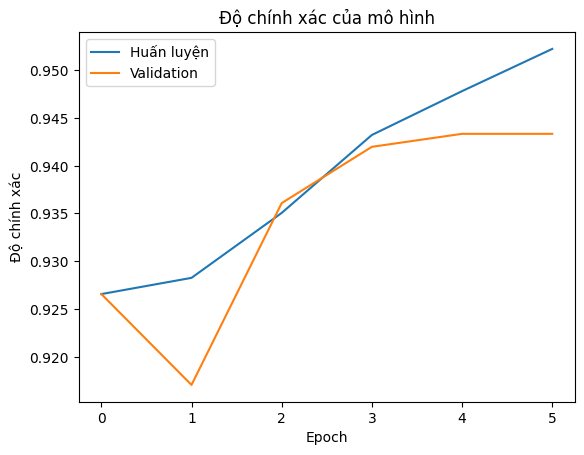

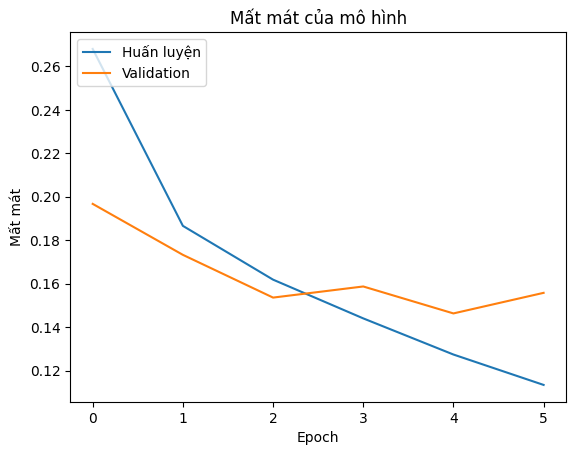

In [18]:
# Đồ thị biểu diễn độ chính xác trong mỗi epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Độ chính xác của mô hình')
plt.ylabel('Độ chính xác')
plt.xlabel('Epoch')
plt.legend(['Huấn luyện', 'Validation'], loc='upper left')
plt.show()

# Đồ thị biểu diễn giá trị mất mát trong mỗi epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Mất mát của mô hình')
plt.ylabel('Mất mát')
plt.xlabel('Epoch')
plt.legend(['Huấn luyện', 'Validation'], loc='upper left')
plt.show()


In [20]:
loss, acc = model.evaluate(x_test, y_test)

print("Độ chính xác trên tập kiểm thử: ", acc)

print("Mất mát trên tập kiểm thử: ", loss)


69/69 [==============================] - 1s 14ms/step - loss: 0.1692 - acc: 0.9461
Độ chính xác trên tập kiểm thử:  0.9460561871528625
Mất mát trên tập kiểm thử:  0.16922418773174286
